# S&P500 Price Prediction

S&P500 consists of the 500 largest companies listed on exchanges in the United States.
I will try to predict the future S&P500 stock price using: feature engineering and feature selection.

Work methods:
- Creation of new input features from existing features.
- Importing features of economic activity indicators with correlativity to the stock market from FRED.
- Filling sparse data using interpolation.
- Data transformation.
- Automated features selection.

Target:
- Beat the benchmark model.

## Importing the libraries:

In [71]:
# Data calculation and analysis libraries
import pandas as pd
import datetime as dt
import numpy as np
import time

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt 

# Data importation
from pandas_datareader import data as pdr
import yfinance as yfin
from fredapi import Fred 
yfin.pdr_override()

# Data engineering libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Spliting data function
from sklearn.model_selection import train_test_split

# Evaluation metrics 
from sklearn.metrics import mean_squared_error

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso

# Constants
randomness = 42

## Import stock data:

In [72]:
# Read and prepare yahoo stock ticker info:
ticker = "SPY"
data = pdr.get_data_yahoo(ticker, start = dt.datetime(1990,1,1), end = dt.datetime.today())

ystock_data = data.copy()
ystock_data.index.names = ['date']
ystock_data.columns = ['open','high','low','close', 'adj_close','volume']

[*********************100%***********************]  1 of 1 completed


In [73]:
ystock_data[['high','low','adj_close','volume']].head(2)

,high,low,adj_close,volume
date,,,,
1993-01-29,43.96875,43.75000,25.334026,1003200
1993-02-01,44.25000,43.96875,25.514214,480500


In [74]:
ystock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7523 entries, 1993-01-29 to 2022-12-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       7523 non-null   float64
 1   high       7523 non-null   float64
 2   low        7523 non-null   float64
 3   close      7523 non-null   float64
 4   adj_close  7523 non-null   float64
 5   volume     7523 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 411.4 KB


## Import supplemental economic data:

In [76]:
# fred ticker and ticker-name dictionery for economic activity indicators:
columns_dic = {
    "unemployment_claims": "ICSA",
    "consumer_goods_orders": "ACOGNO",
    "capital_goods_orders": "ANDENO",
    "new_housing_permits": "PERMIT",
    "money_supply": "WM2NS",
    "interest_rate": "T10YFF",
    "consumer_sentiment": "UMCSENT",
    "delivery_time": "DTCDFNA066MNFRBPHI",
    "crude_birth_rate": "SPDYNCBRTINUSA",
    "net_migration": "SMPOPNETMUSA",
    "energy_price": "PNRGINDEXM",
    "gini": "SIPOVGINIUSA",
    "usa_pop": "POPTOTUSA647NWDB",
    "pop_growth": "SPPOPGROWUSA",
    "dependency_ratio": "SPPOPDPNDOLUSA",
    "world_pop": "SPPOPTOTLWLD",
    "volatility": "VIXCLS",
}

In [77]:
# fill gaps in fred data using interpolation:
def day_fill_smooth(df):
    start_date = df.index.min() - pd.DateOffset(day=1)
    dates = pd.date_range(start_date, df.index.max(), freq='D')
    dates.name = 'date'
    df2 = df.reindex(dates)
    days_apart = round(len(df2)/len(df))
    
    if days_apart > 30:
        return df2.interpolate(method='quadratic')
    else:
        return df2.interpolate(method='time')

# Get and fill data from fred:
def get_fred(dic):
    full_data = {}
    filled_data = {}
    for i in dic:
        full_data[i] = fred.get_series(dic[i],timeout=60)
        filled_data[i] = day_fill_smooth(full_data[i])
        
    return pd.DataFrame(filled_data), pd.DataFrame(full_data)

In [79]:
%%time
EAindicators, fred_source = get_fred(columns_dic)

CPU times: total: 4.83 s
Wall time: 19.2 s


In [80]:
fred_source.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19043 entries, 1950-01-01 to 2022-12-09
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unemployment_claims    2918 non-null   float64
 1   consumer_goods_orders  369 non-null    float64
 2   capital_goods_orders   369 non-null    float64
 3   new_housing_permits    754 non-null    float64
 4   money_supply           2192 non-null   float64
 5   interest_rate          15219 non-null  float64
 6   consumer_sentiment     630 non-null    float64
 7   delivery_time          655 non-null    float64
 8   crude_birth_rate       61 non-null     float64
 9   net_migration          12 non-null     float64
 10  energy_price           370 non-null    float64
 11  gini                   32 non-null     float64
 12  usa_pop                62 non-null     float64
 13  pop_growth             61 non-null     float64
 14  dependency_ratio       62 non-null   

The raw data imported start at different years and the frequency of measurements is difference between categories.
It will be fixed using time and quadratic interpolation.

### Interpolation:

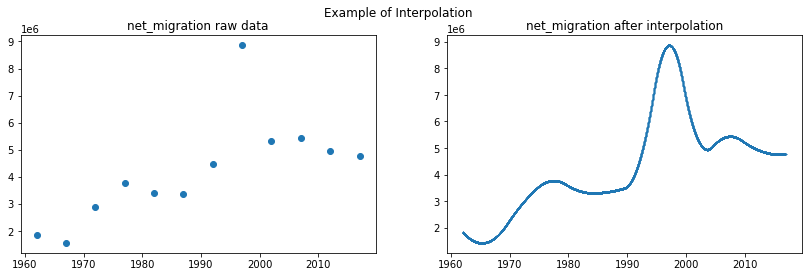

In [81]:
plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.scatter(fred_source['net_migration'].index, fred_source['net_migration'])
plt.title('net_migration raw data')

plt.subplot(122)
plt.scatter(EAindicators['net_migration'].index ,EAindicators['net_migration'], s= 0.1)
plt.title('net_migration after interpolation')

plt.suptitle('Example of Interpolation')
plt.show();

We can see that even with 5 years of seperation between measurements interpolation does good job filling in the gaps.

### Study supplemental data:

In [82]:
EAindicators.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26641 entries, 1950-01-01 to 2022-12-09
Freq: D
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unemployment_claims    20420 non-null  float64
 1   consumer_goods_orders  11201 non-null  float64
 2   capital_goods_orders   11201 non-null  float64
 3   new_housing_permits    22920 non-null  float64
 4   money_supply           15338 non-null  float64
 5   interest_rate          22257 non-null  float64
 6   consumer_sentiment     25537 non-null  float64
 7   delivery_time          19908 non-null  float64
 8   crude_birth_rate       21916 non-null  float64
 9   net_migration          20090 non-null  float64
 10  energy_price           11232 non-null  float64
 11  gini                   16437 non-null  float64
 12  usa_pop                22282 non-null  float64
 13  pop_growth             21916 non-null  float64
 14  dependency_ratio       22282 

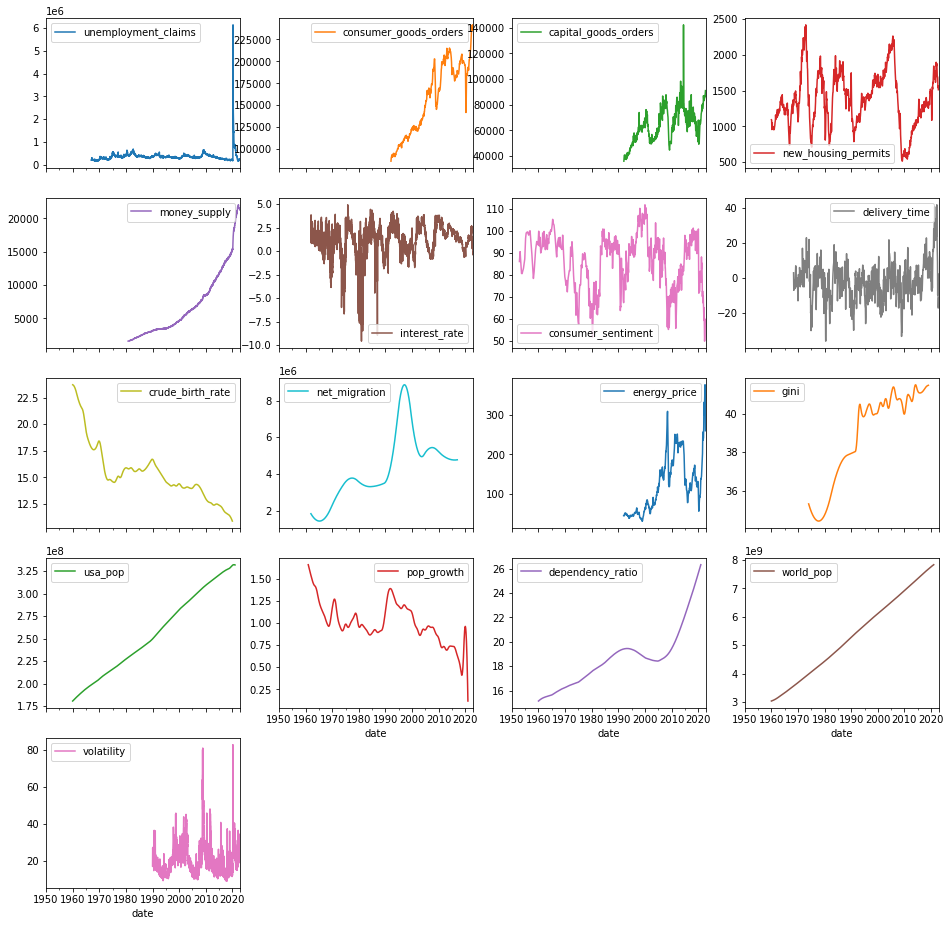

In [83]:
EAindicators.plot(subplots=True, layout=(5,4), figsize=(16,16));

Now the data is filled in daily resolution and can be combined with the stock price.

## Combine and create new features:

In [84]:
def RSI(data, n):
    # relative strength index
    up_df, down_df = data['change'].copy(), data['change'].copy()

    up_df.loc[up_df<0] = 0
    down_df.loc[down_df>0] = 0
    down_df = down_df.abs()

    ewma_up = up_df.transform(lambda x: x.ewm(span = n).mean())
    ewma_down = down_df.transform(lambda x: x.ewm(span = n).mean())
    relative_strength = ewma_up / ewma_down

    relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))
    return relative_strength_index

In [85]:
#  create new features
def make_features(data, max_lag=0, SHORT=5, MEDIUM=20, LONG=120):

    data["year"] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    if max_lag != 0:
        for lag in range(1, max_lag + 1):
            data['lag_{}'.format(lag)] = data['adj_close'].shift(lag)

    data['change'] = data['adj_close'].diff()
    data['change_rate'] = data['adj_close'].pct_change(periods = MEDIUM)
    data['change_rate'][data['change_rate'] == np.inf] = 1
    data['change_rate'][data['change_rate'] == -np.inf] = -1
        
    data['rolling_{}'.format(SHORT)] = data['adj_close'].ewm(SHORT).mean()
    data['rolling_{}'.format(MEDIUM)] = data['adj_close'].ewm(MEDIUM).mean()
    data['rolling_{}'.format(LONG)] = data['adj_close'].ewm(LONG).mean()

    data['rolling_{}H'.format(SHORT)] = data['adj_close'].rolling(SHORT).max()
    data['rolling_{}L'.format(SHORT)] = data['adj_close'].rolling(SHORT).min()
    data['rolling_{}HH'.format(SHORT)] = data['high'].rolling(SHORT).max()
    data['rolling_{}LL'.format(SHORT)] = data['low'].rolling(SHORT).min()
    
    data['rolling_{}H'.format(MEDIUM)] = data['adj_close'].rolling(MEDIUM).max()
    data['rolling_{}L'.format(MEDIUM)] = data['adj_close'].rolling(MEDIUM).min()
    data['rolling_{}HH'.format(MEDIUM)] = data['high'].rolling(MEDIUM).max()
    data['rolling_{}LL'.format(MEDIUM)] = data['low'].rolling(MEDIUM).min()
    
    data['rolling_{}H'.format(LONG)] = data['adj_close'].rolling(LONG).max()
    data['rolling_{}L'.format(LONG)] = data['adj_close'].rolling(LONG).min()
    data['rolling_{}HH'.format(LONG)] = data['high'].rolling(LONG).max()
    data['rolling_{}LL'.format(LONG)] = data['low'].rolling(LONG).min()
    
    data['k_percent'] = 100 * ((data['adj_close'] - data['rolling_{}LL'.format(SHORT)]) / (data['rolling_{}HH'.format(SHORT)] - data['rolling_{}LL'.format(SHORT)]))
    data['momentum'] = 100*((data['adj_close'] - data['rolling_{}L'.format(SHORT)]) / (data['rolling_{}H'.format(SHORT)] - data['rolling_{}L'.format(SHORT)]))
    data['r_percent'] = ((data['rolling_{}H'.format(SHORT)] - data['adj_close']) / (data['rolling_{}H'.format(SHORT)] - data['rolling_{}L'.format(SHORT)])) * - 100
    
    data['macd'] = data['rolling_{}'.format(SHORT)] - data['rolling_{}'.format(MEDIUM)]
    data['macd_ema'] = data['macd'].ewm(5).mean()
    data['rsi'] = RSI(data,SHORT)
    
    return data

### Check partial autocorrelation for 'adj_close':

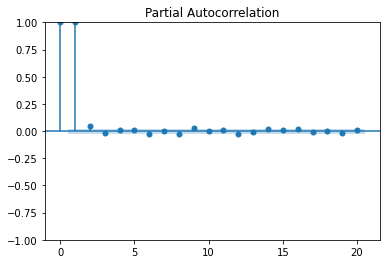

In [86]:
import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(ystock_data.adj_close,lags = 20);

Only one previous day is significant.

### Combine all the features and create a target for prediction:

In [87]:
# Create adj_target to predict:
days_to_predict = 20

EAindicators2 = pd.concat([EAindicators,ystock_data[['high','low','adj_close','volume']]], axis=1).dropna()
EAindicators2['adj_target'] = EAindicators2.adj_close.shift(-days_to_predict)
data_e = EAindicators2.copy().dropna()
data_model = make_features(data_e)
data_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6006 entries, 1993-01-29 to 2016-12-01
Data columns (total 49 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unemployment_claims    6006 non-null   float64
 1   consumer_goods_orders  6006 non-null   float64
 2   capital_goods_orders   6006 non-null   float64
 3   new_housing_permits    6006 non-null   float64
 4   money_supply           6006 non-null   float64
 5   interest_rate          6006 non-null   float64
 6   consumer_sentiment     6006 non-null   float64
 7   delivery_time          6006 non-null   float64
 8   crude_birth_rate       6006 non-null   float64
 9   net_migration          6006 non-null   float64
 10  energy_price           6006 non-null   float64
 11  gini                   6006 non-null   float64
 12  usa_pop                6006 non-null   float64
 13  pop_growth             6006 non-null   float64
 14  dependency_ratio       6006 non-null  

44 New features Created.


## Splitting The Data (70 : 15 : 15):
Before dealing with the missing values and execution of the features engineering process, we will split the data to train, validation and test.

In [88]:
# splitting the data to train, validation and test using the train_test_split function
train_temp, test = train_test_split(data_model.dropna(), shuffle=False, test_size=0.1)
train, valid = train_test_split(train_temp, shuffle=False, test_size=0.11)

# saving the target varaible in a separate variable
target_train = train['adj_target']
features_train = train.drop('adj_target', axis=1)

target_valid = valid['adj_target']
features_valid = valid.drop('adj_target', axis=1)

target_test = test['adj_target']
features_test = test.drop('adj_target', axis=1)

data_model.shape, train.shape, valid.shape, test.shape

((6006, 49), (4715, 49), (583, 49), (589, 49))

## Features engineering:

### Features transformation:

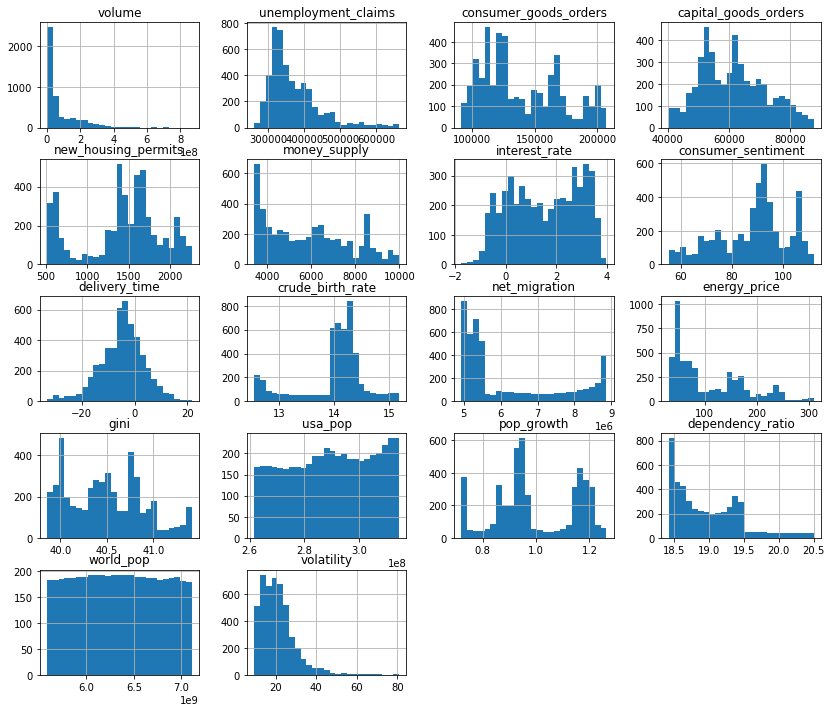

In [89]:
train[EAindicators.columns.insert(0,'volume')].hist( figsize=(14,12),bins = 25);

In [90]:
import scipy.stats as stat
import pylab 

#### Check whether feature is guassian or normal distributed
#### Q-Q plot
def plot_data(df,feature):
    print(feature)
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    df[feature].hist()
    plt.subplot(1,2,2)
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.show()
    

volume


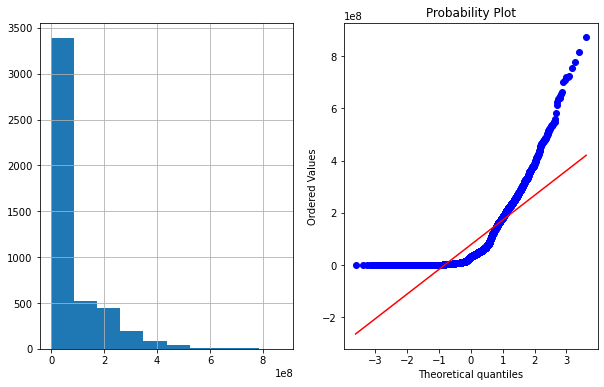

log


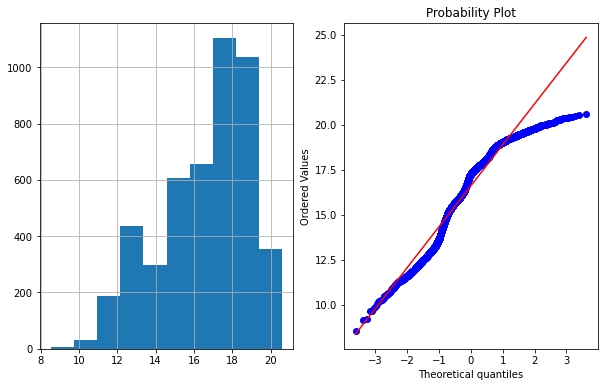

reciprocal


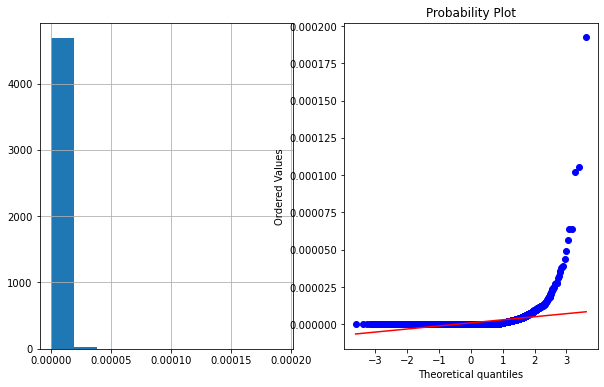

sqaure


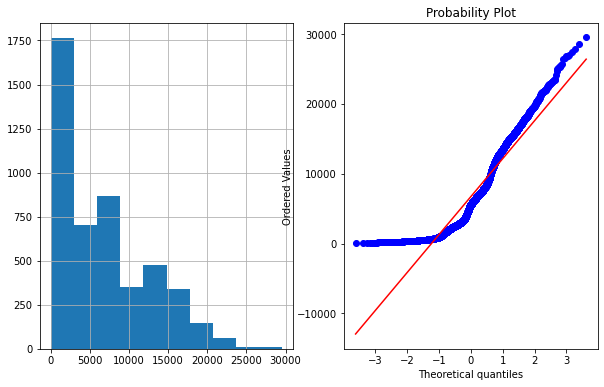

exponential


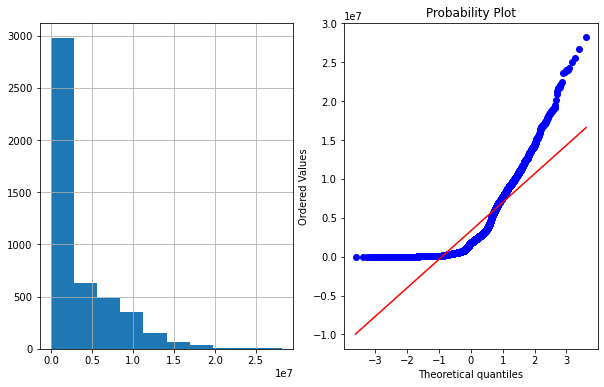

Boxcox


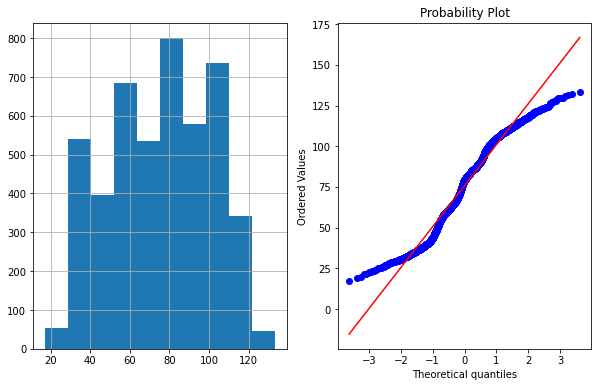

In [91]:
# manually choose the best transformation for the data
df = train.copy()
value = 'volume'

df['log']=np.log(df[value])
df['reciprocal']=1/df[value]
df['sqaure']=df[value]**(1/2)
df['exponential']=df[value]**(1/1.2)
df['Boxcox'],parameters=stat.boxcox(df[value])

plot_data(df, value)
plot_data(df,'log')
plot_data(df,'reciprocal')
plot_data(df,'sqaure')
plot_data(df,'exponential')
plot_data(df,'Boxcox')

I will manualy select the best transformations for the imported features.

In [92]:
#volume                   Boxcox
#unemployment_claims      non
#consumer_goods_orders    Boxcox
#capital_goods_orders     non
#new_housing_permits      Boxcox
#money_supply             non
#interest_rate            non
#consumer_sentiment       Boxcox
#delivery_time            non
#crude_birth_rate         non
#net_migration            non
#energy_price             Boxcox
#gini                     non
#usa_pop                  non
#pop_growth               non
#dependency_ratio         non
#world_pop                non
#volatility               Boxcox

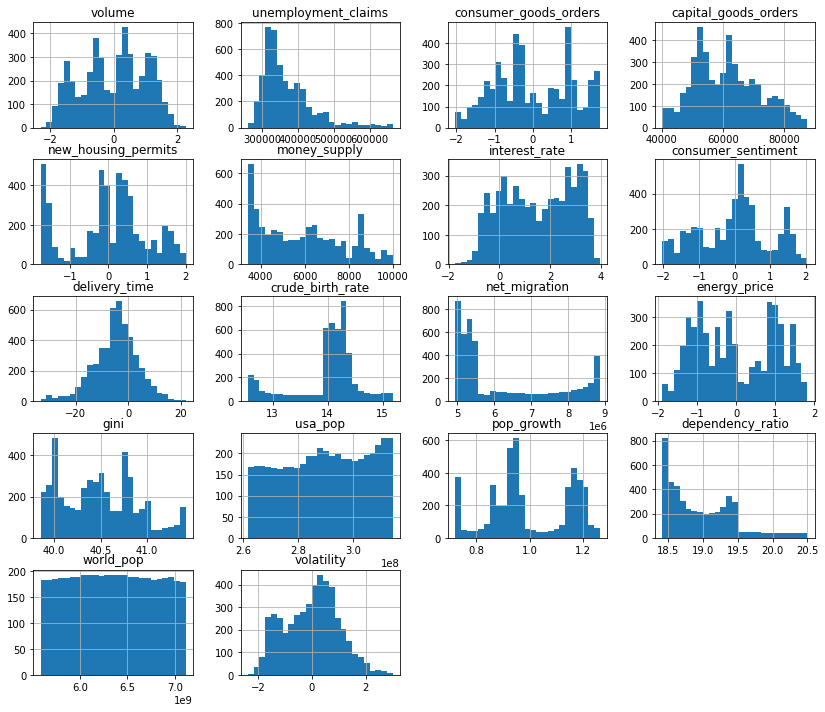

In [93]:
from sklearn.preprocessing import PowerTransformer

boxcox_trans_f = ['volume', 'consumer_goods_orders', 'new_housing_permits', 
                  'consumer_sentiment', 'energy_price', 'volatility']

def power_trans( train, valid, test, col):
    power = PowerTransformer(method='box-cox')
    
    train_t = pd.DataFrame(power.fit_transform(train[col]), columns = col, index = train.index )
    valid_t = pd.DataFrame(power.transform(valid[col]), columns = col, index = valid.index)
    test_t = pd.DataFrame(power.transform(test[col]), columns = col, index = test.index)
        
    train_t = pd.concat([train_t, train.drop(col, axis=1)], axis=1)
    valid_t = pd.concat([valid_t, valid.drop(col, axis=1)], axis=1)
    test_t = pd.concat([test_t, test.drop(col, axis=1)], axis=1)
    
    return train_t, valid_t, test_t

train_t, valid_t, test_t = power_trans( features_train, features_valid, features_test, boxcox_trans_f)

train_t[EAindicators.columns.insert(0,'volume')].hist( figsize=(14,12),bins = 25);

### Features scaling:

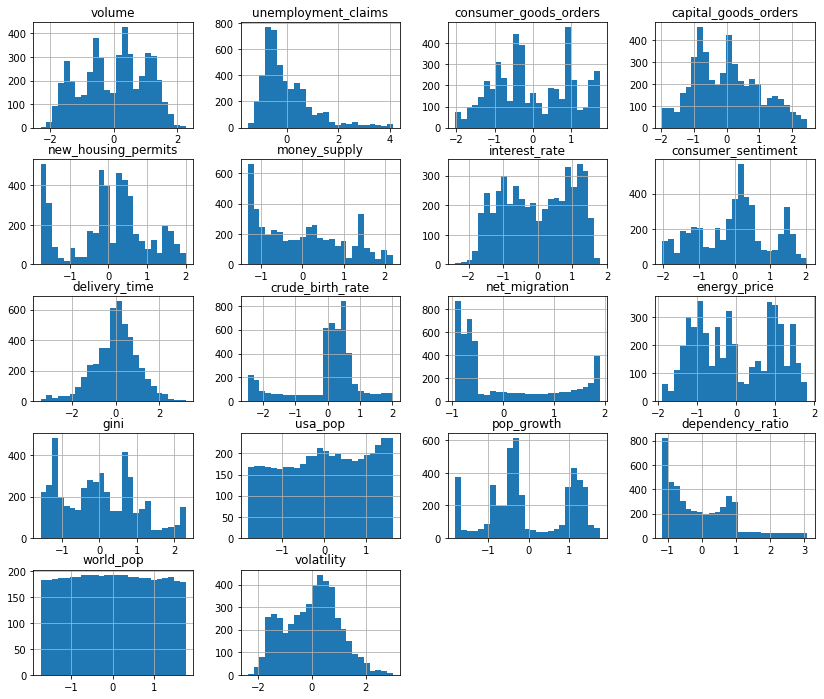

In [94]:
from sklearn.preprocessing import StandardScaler

def scaler_trans( train, valid, test, col):
    scaler = StandardScaler()
    
    train_t = pd.DataFrame(scaler.fit_transform(train[col]), columns = col, index = train.index)
    valid_t = pd.DataFrame(scaler.transform(valid[col]), columns = col, index = valid.index)
    test_t = pd.DataFrame(scaler.transform(test[col]), columns = col, index = test.index)
    
    train_t = pd.concat([train_t, train.drop(col, axis=1)], axis=1)
    valid_t = pd.concat([valid_t, valid.drop(col, axis=1)], axis=1)
    test_t = pd.concat([test_t, test.drop(col, axis=1)], axis=1)
    
    return train_t, valid_t, test_t

train_t, valid_t, test_t = scaler_trans( train_t, valid_t, test_t, EAindicators.columns.insert(0,'volume'))

train_t[EAindicators.columns.insert(0,'volume')].hist( figsize=(14,12),bins = 25);

* Created 46 new features overall.

## Compare different models:

In [95]:
list_of_models = [LinearRegression(),
                  Lasso(alpha=0.05, random_state=randomness),
                  Ridge(), 
                  ElasticNet(random_state=randomness)]

In [96]:
def calculate_mape(y_true, y_pred): 
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100    
    return mape

In [97]:
def model_evaluation( model ,features_train,target_train,features_test,target_test):
    
    t0= time.time()
    model.fit(features_train, target_train)
    predictions1 = model.predict(features_train)
    predictions2 = model.predict(features_test)
    t2= time.time()
    
    RMSE1 = mean_squared_error(target_train, predictions1)**0.5
    RMSE2 = mean_squared_error(target_test, predictions2)**0.5
    MAPE = calculate_mape(target_test, predictions2)
    
    score= {'model': [str(model).split('(', 1)[0]],
            'training_rmse': [RMSE1],
            'test_rmse': [RMSE2],
            'test_mape': [MAPE],
            'total_time': [t2 - t0]
           }  

    return pd.DataFrame(score)

In [98]:
def model_comparison(features_train, target_train, features_test, target_test , list_of_models = list_of_models ):
    
    model_score_ev =  pd.DataFrame()
    
    for mod in list_of_models:
        model_score_ev = model_score_ev.append(model_evaluation(mod,
                                                               features_train,
                                                                target_train,
                                                                features_test,
                                                                target_test))
    
    return model_score_ev[['model','training_rmse','test_rmse','test_mape']].sort_values(by = "test_mape")

In [100]:
model_comparison(train_t, target_train, valid_t, target_valid)

,model,training_rmse,test_rmse,test_mape
0,ElasticNet,3.652106,4.259440,2.688573
0,Lasso,3.365456,7.078861,4.097664
0,Ridge,3.215834,8.781517,4.991956
0,LinearRegression,3.145467,12.761272,7.599394


In [126]:
model_comparison(features_train, target_train, features_valid, target_valid)

,model,training_rmse,test_rmse,test_mape
0,ElasticNet,3.384120,6.134954,3.431068
0,Lasso,3.284383,9.805400,5.485681
0,Ridge,3.117702,11.087105,6.316787
0,LinearRegression,3.098032,16.682753,9.625711


## Automated feature selection:

In [137]:
%%time

from mlxtend.feature_selection import SequentialFeatureSelector

scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(train_t)

auto_mape = []
minrange =  4
maxrange =  30 #len(trans_dt.columns)-10

for i in range(minrange, maxrange):
    results = []
    sfs = SequentialFeatureSelector(ElasticNet(random_state=randomness), forward=False, k_features=i)
    sfs.fit(features_train_scaled, target_train)
    reslt = model_comparison(train_t[train_t.columns[np.array(sfs.k_feature_idx_)]], 
                             target_train, 
                             valid_t[train_t.columns[np.array(sfs.k_feature_idx_)]], 
                             target_valid).test_mape.iloc[0]
    results.append(i)
    results.append(reslt)
    auto_mape.append(results)

auto_mape = pd.DataFrame(auto_mape,columns=['n_features','test_mape'])
best_fn = auto_mape.n_features[auto_mape.test_mape.idxmin()]
print("Best number of features is:", best_fn )

Best number of features is: 28
CPU times: total: 5h 22min 16s
Wall time: 1h 26min 40s


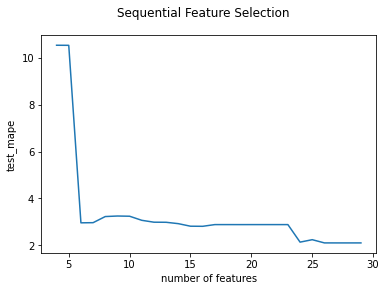

In [138]:
plt.plot(auto_mape.n_features, auto_mape.test_mape)
plt.suptitle('Sequential Feature Selection')
plt.xlabel('number of features')
plt.ylabel('test_mape')
plt.show()

In [133]:
%%time

sfs = SequentialFeatureSelector(ElasticNet(random_state=randomness), forward=False, k_features= int(best_fn) )
sfs.fit(features_train_scaled, target_train)

cols_dropped = [col for col in train_t.columns if col not in train_t.columns[np.array(sfs.k_feature_idx_)]]
best_col = train_t.columns[np.array(sfs.k_feature_idx_)]

print("Features dropped: ", len(cols_dropped),"\n", cols_dropped)
print("\nSelected features: ", len(best_col),"\n", best_col.values)

Features dropped:  20 
 ['volume', 'unemployment_claims', 'consumer_goods_orders', 'capital_goods_orders', 'new_housing_permits', 'interest_rate', 'delivery_time', 'crude_birth_rate', 'energy_price', 'gini', 'pop_growth', 'dependency_ratio', 'volatility', 'rolling_120L', 'rolling_120HH', 'rolling_120LL', 'k_percent', 'macd', 'macd_ema', 'rsi']

Selected features:  28 
 ['money_supply' 'consumer_sentiment' 'net_migration' 'usa_pop' 'world_pop'
 'high' 'low' 'adj_close' 'year' 'month' 'day' 'dayofweek' 'change'
 'change_rate' 'rolling_5' 'rolling_20' 'rolling_120' 'rolling_5H'
 'rolling_5L' 'rolling_5HH' 'rolling_5LL' 'rolling_20H' 'rolling_20L'
 'rolling_20HH' 'rolling_20LL' 'rolling_120H' 'momentum' 'r_percent']
CPU times: total: 7min 39s
Wall time: 1min 59s


In [135]:
model_comparison(train_t[best_col], target_train, valid_t[best_col], target_valid)

,model,training_rmse,test_rmse,test_mape
0,Ridge,3.459237,3.606715,2.100444
0,LinearRegression,3.450365,3.670628,2.178511
0,Lasso,3.521233,3.980485,2.464187
0,ElasticNet,3.656819,4.440759,2.794996


In [139]:
model_comparison(features_train[best_col], target_train, features_valid[best_col], target_valid)

,model,training_rmse,test_rmse,test_mape
0,Ridge,3.415183,3.660883,2.085004
0,LinearRegression,3.414747,3.646508,2.090218
0,Lasso,3.456603,3.674006,2.106123
0,ElasticNet,3.462595,3.716235,2.160285


## Testing The Best Model:
- ElasticNet()

In [136]:
print('Training using selected features:')
print(model_comparison(pd.concat([train_t, valid_t], axis=0)[best_col], 
                 pd.concat([target_train, target_valid], axis=0), 
                 test_t[best_col], 
                 target_test, 
                 list_of_models = [ElasticNet(random_state=randomness)]))

Training using selected features:
        model  training_rmse  test_rmse  test_mape
0  ElasticNet       3.666078   5.924409   2.506777


## Sanity check:
- Comparing model accuracy vs. benchmark model using single feature ( 'adj_target' ) in a range of prediction distances.

In [134]:
print("""\nTraining using only 'adj_close':""")
print(model_comparison(pd.concat([train_t, valid_t], axis=0)[['adj_close']], 
                 pd.concat([target_train, target_valid], axis=0), 
                 test_t[['adj_close']], 
                 target_test, 
                 list_of_models = [LinearRegression()]))


Training using only 'adj_close':
              model  training_rmse  test_rmse  test_mape
0  LinearRegression       3.726731   5.935607   2.522346


## Summary and Conclusions:
Stock:
- S&P500

Timeframe: 
- '1993-01-29' until '2022-12-12'

Prediction target: 
- +20 days farward

Feature creation:
- 17 features imported, 5 selected for the final model
- 29 features created, 20 selected for the final model

Imported features selected:
- 'money_supply' 
- 'consumer_sentiment' 
- 'net_migration' 
- 'usa_pop' 
- 'world_pop'

Train, test, validation split: 
- 80-10-10

Model:
- Selected model: ElasticNet() with validation MAPE of: 3.43
- Features transformation decreased validation MAPE of: 2.69
- Features selection decreased validation MAPE to: 2.16

Best modle:
- ElasticNet() + selected features + transformation test MAPE of: 2.506

Benchmark:
- LinearRegression() with single feature 'adj_close', test MAPE of: 2.522

Conclusion:
- Up to 2.5% of the real stock price can be predicted 20 working days in advance using the model